In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import PrintNNinfo as out
import os
from scipy.ndimage import gaussian_filter1d, gaussian_filter

In [115]:
def CreateERnetwork(cell_types, ps):
    n = len(ps)
    syn_types = np.arange(n*n).reshape(n, n)
    cnt_map = np.ones([len(cell_types), len(cell_types)], dtype=int) * (-1)
    
    for i, cpre in enumerate(cell_types):
        for j, cpost in enumerate(cell_types):
            if i != j:
                if np.random.uniform() < ps[cpre][cpost]:
                    cnt_map[i][j] = syn_types[cpre][cpost]
    return cnt_map

def get_Poisson_t(prob, N, tmax, dt, t0=0):
    times = np.arange(t0, tmax, dt)
    ts = []
    for i in range(N):
        rand = np.random.uniform(low=0, high=1, size=len(times))
        ids = rand < prob * dt
        ts.append(times[ids])
    return ts

def select_targets(n_stims, n_cells, n_overlap):
    targets = []
    for i in range(n_overlap):
        targets = np.concatenate((targets, [i for i in range(n_cells)]))
    targets = list(targets.astype(np.int))
        
    target_ids = []
    for i in range(n_stims):
        tid = [np.random.choice(targets)]
        targets.remove(tid)
        for j in range(n_overlap-1):
            n = np.random.choice(targets)
            while n in tid:
                n = np.random.choice(targets)
            tid.append(n)
            targets.remove(n)
        target_ids.append(tid)
    return target_ids

def set_ext_types(target_ids, n_ext_exc, cell_types, ext_syn_types):
    n_ext_inh = len(target_ids) - n_ext_exc
#     ext_syn_types = [[0, 1], [2, 3]] # ext_PN -> ? / ext_Inh -> ?
    ext_types = []
    for i, tid in enumerate(target_ids):
        ext_types.append([])
        if i < n_ext_exc:
            pre = 0
        else:
            pre = 1
        for n in tid:
            ext_types[-1].append(ext_syn_types[pre][cell_types[n]])
    return ext_types
    


In [116]:
tmax = 10000
dt = 0.01
rand = np.random.uniform(low=0, high=1, size=int(tmax/dt))

In [117]:
np.random.seed(10100)

n_exc = 1000
n_inh = 250
n_stims = 1250

# set PN cell type & cells parameter
params_pn = {'tau':20, 'r':100, 'e':-65, 'vth':-40, 'vahp':-80, 'v0':-65, 'vmax':30, 't_refrac':10}
params_pv = {'tau':5, 'r':100, 'e':-65, 'vth':-50, 'vahp':-80, 'v0':-65, 'vmax':30, 't_refrac':0}
# set synapse type & parameter
syn_pn2pn = {'gmax':2e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':1}
syn_pn2pv = {'gmax':3e-3, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':1}
syn_pv2pn = {'gmax':2e-3, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':1}
syn_pv2pv = {'gmax':2e-3, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':1}

syn_type_params = [syn_pn2pn, syn_pn2pv, syn_pv2pn, syn_pv2pv]

# set network parameters
ps = [[0.2, 0.2], [0.3, 0.3]] # PN->PN/Inh, Inh->PN/Inh

n_cells = n_exc + n_inh

cell_types = []
for i in range(n_cells):
    if i < n_exc:
        cell_types.append(0)
    else:
        cell_types.append(1)

cnt_map = CreateERnetwork(cell_types, ps)

# stimulation
ext_pn2pn = {'gmax':0.05, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
ext_pn2pv = {'gmax':0.05, 'tau_r':0.3, 'tau_d':6, 'e':0, 'd':0}
ext_pv2pn = {'gmax':0.05, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}
ext_pv2pv = {'gmax':0.05, 'tau_r':0.5, 'tau_d':6, 'e':-80, 'd':0}

ext_syn_type_params = [ext_pn2pn, ext_pn2pv, ext_pv2pn, ext_pv2pv]

t_stims = get_Poisson_t(0.1, n_stims, 9000, dt, t0=1000)
target_ids = select_targets(n_stims, n_cells, 3)
ext_types = set_ext_types(target_ids, 75, cell_types, [[0, 1], [2, 3]])

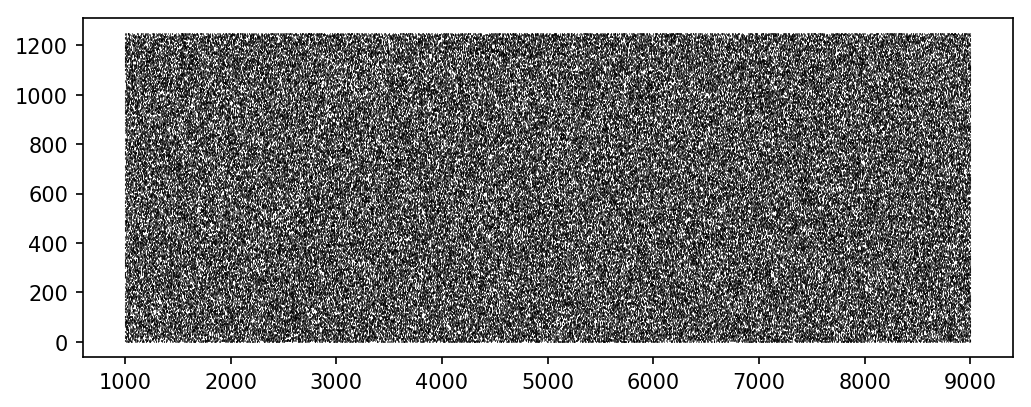

In [118]:
# external stim info
plt.figure(dpi=150, figsize=(8, 3))
for i, t in enumerate(t_stims):
    plt.vlines(t, i-0.5, i+0.5, color='k', lw=0.5)
plt.show()

In [119]:
out.print_nn_params('./parameter/', 'ntk_all', cell_types, cnt_map, [params_pn, params_pv], syn_type_params,
                    target_ids, ext_types, t_stims, ext_syn_type_params, overwrite=True)

./parameter/ntk_all_cell.csv exists
./parameter/ntk_all_syn.csv exists
./parameter/ntk_all_t_spike.csv exists
done



# Analysis

In [93]:
def getSTFFT(x, t, wbin=50000, mbin=1000, dt=0.01, maxf=200):
    ids = np.arange(wbin//2, len(x)-wbin//2, mbin)
    f = np.fft.fftfreq(wbin, dt/(1e3))
    f = f[:wbin//2]
    idf = (f<200) & (f>1)
    psd = np.zeros([sum(idf), len(ids)])
    window = np.hanning(wbin-1)
    for n, i in enumerate(ids):
        y = x[i-wbin//2:(i+wbin//2-1)] * window
        fx = np.fft.fft(y)/wbin
        fx = abs(fx[:wbin//2])
        psd[:, n] = fx[idf]
    return t[ids], f[idf], psd
    
    
def getFFT(x, idt, dt):
    fx = np.fft.fft(x[idt]) / sum(idt)
    f = np.fft.fftfreq(sum(idt), dt/(1e3))
    fx = abs(fx[:int(sum(idt)//2)])
    f = f[:int(sum(idt)//2)]
    return f, fx

In [120]:
times, vcells = out.readOut("./vcells_all_v.csv")
_, icells = out.readOut("./vcells_all_i.csv")
tspks = []
for i in range(vcells.shape[1]):
    tspks.append(times[vcells[:, i] == 30])

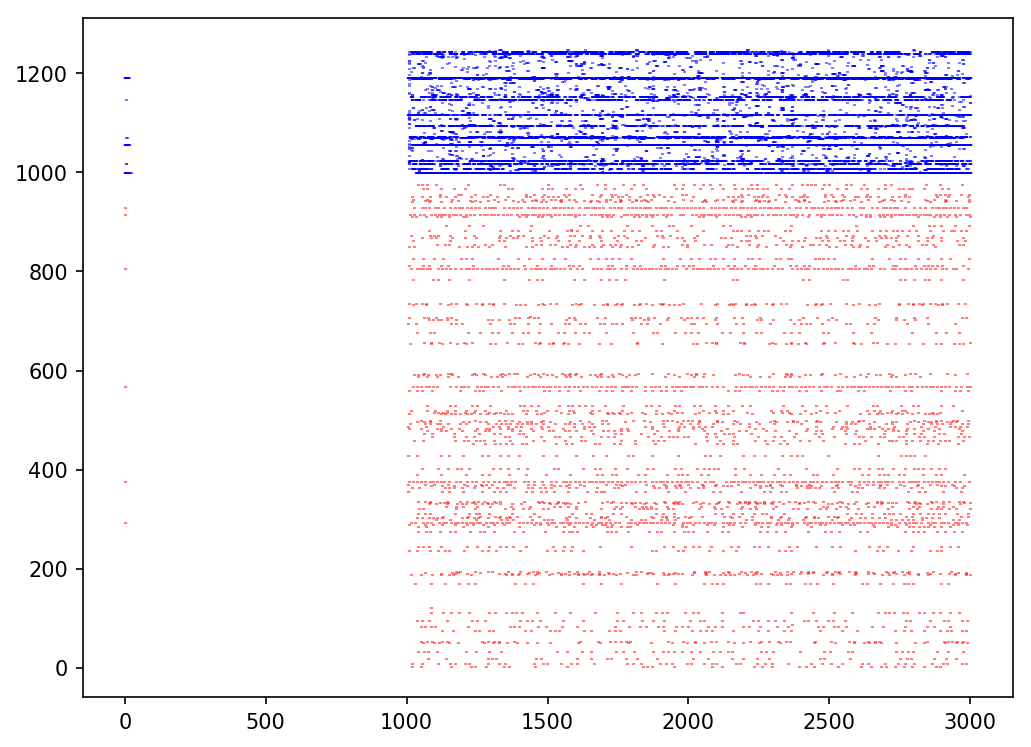

In [121]:
plt.figure(dpi=150, figsize=(8, 6))
for i, t in enumerate(tspks):
    if i < n_exc:
        color = 'r'
    else:
        color = 'b'
    plt.vlines(t, i-0.5, i+0.5, color=color)
# plt.ylim([100, 120])
plt.show()

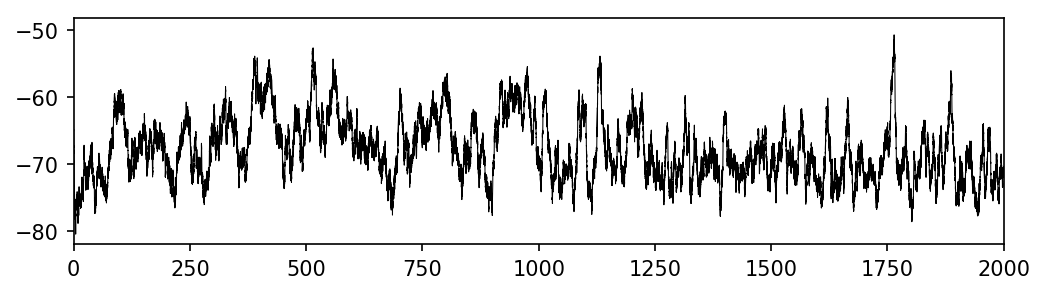

In [122]:
n = 120

plt.figure(dpi=150, figsize=(8, 2))
plt.plot(times, vcells[:, n], 'k', lw=0.5)

# plt.twinx()
# plt.plot(times, icells[:, n], 'g', lw=0.5)

plt.xlim([0, 2000])
plt.show()

In [123]:
vsum = np.average(vcells, axis=1)

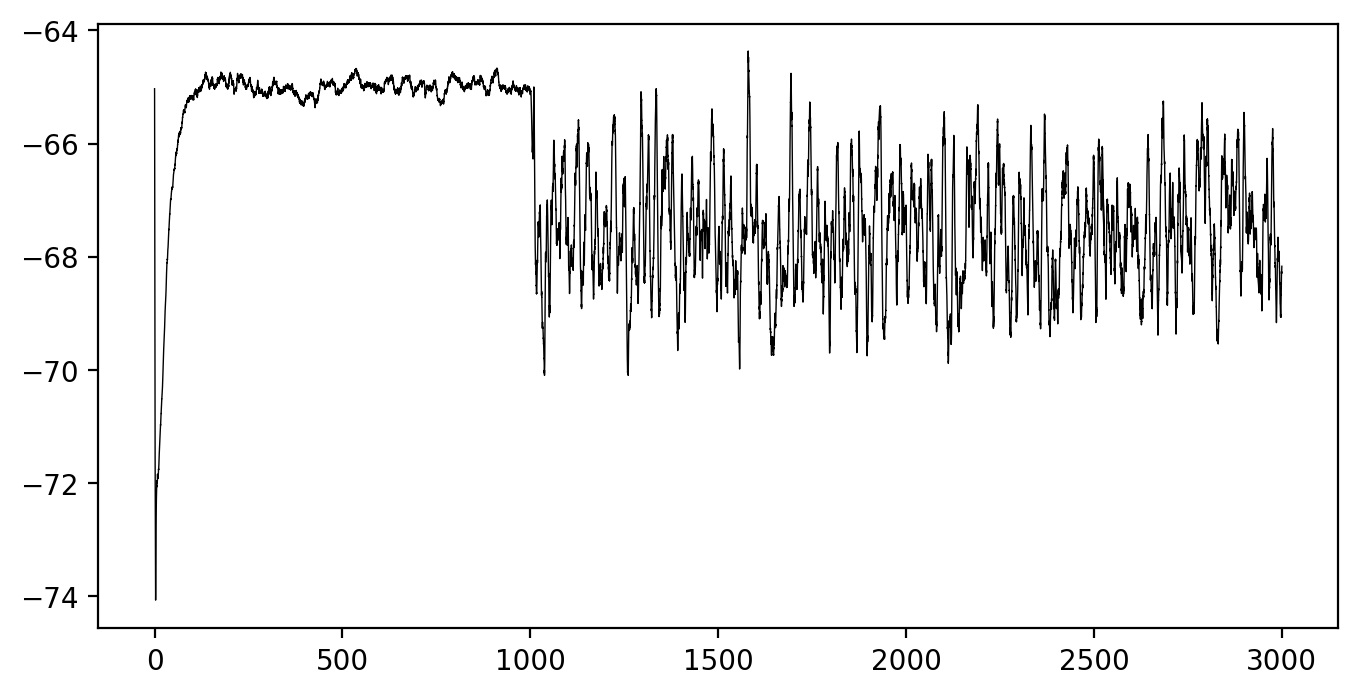

In [124]:
sv = gaussian_filter1d(vsum, 5)

plt.figure(dpi=200, figsize=(8, 4))
plt.plot(times, sv, 'k', lw=0.5)
# plt.xlim([250, 260])
plt.show()

In [125]:
f, fx = getFFT(sv, (times>100)&(times<2000), 0.01)

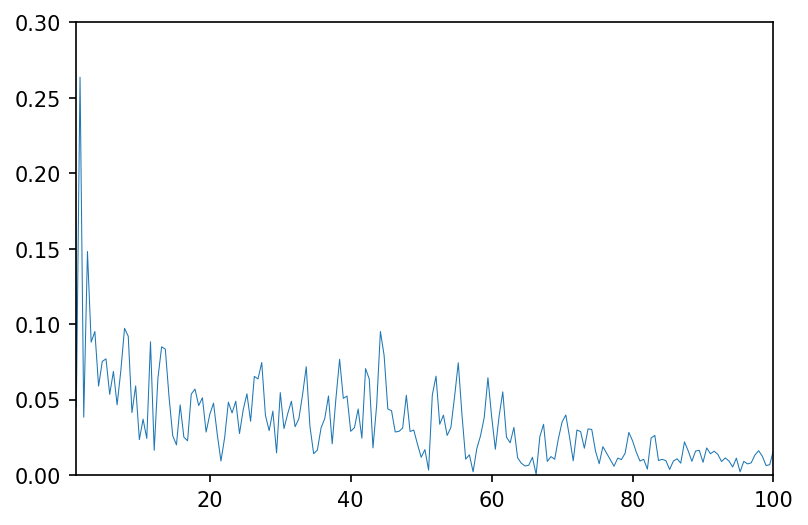

In [126]:
plt.figure(dpi=150)
plt.plot(f, fx, lw=0.5)
# plt.plot(f2, fx2, lw=0.5)
plt.xlim([1, 100])
plt.ylim([0, 0.3])
plt.show()

In [127]:
t, f, psd = getSTFFT(vsum, times)
idf = f>10
txy, fxy = np.meshgrid(t, f[idf])

In [128]:
im = gaussian_filter(psd[idf, :], 2)

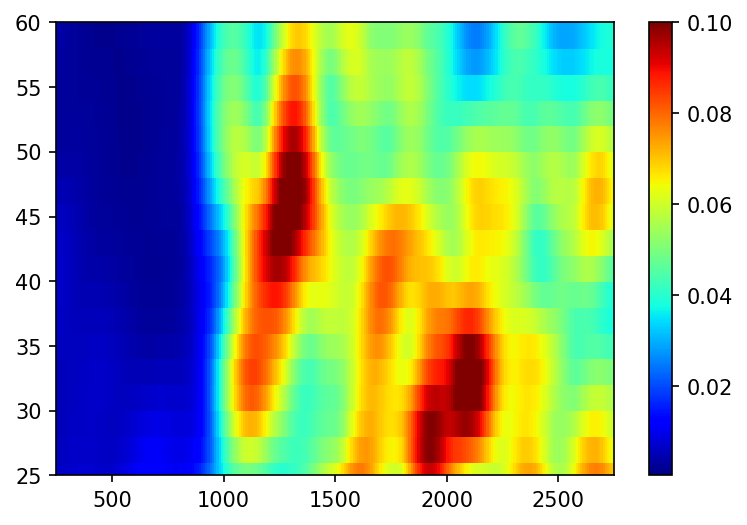

In [130]:
plt.figure(dpi=150)
plt.pcolormesh(txy, fxy, im, cmap='jet', vmax=0.1)
# plt.xlim([0, 1000])
plt.colorbar()
plt.ylim([25, 60])

plt.show()

250.0